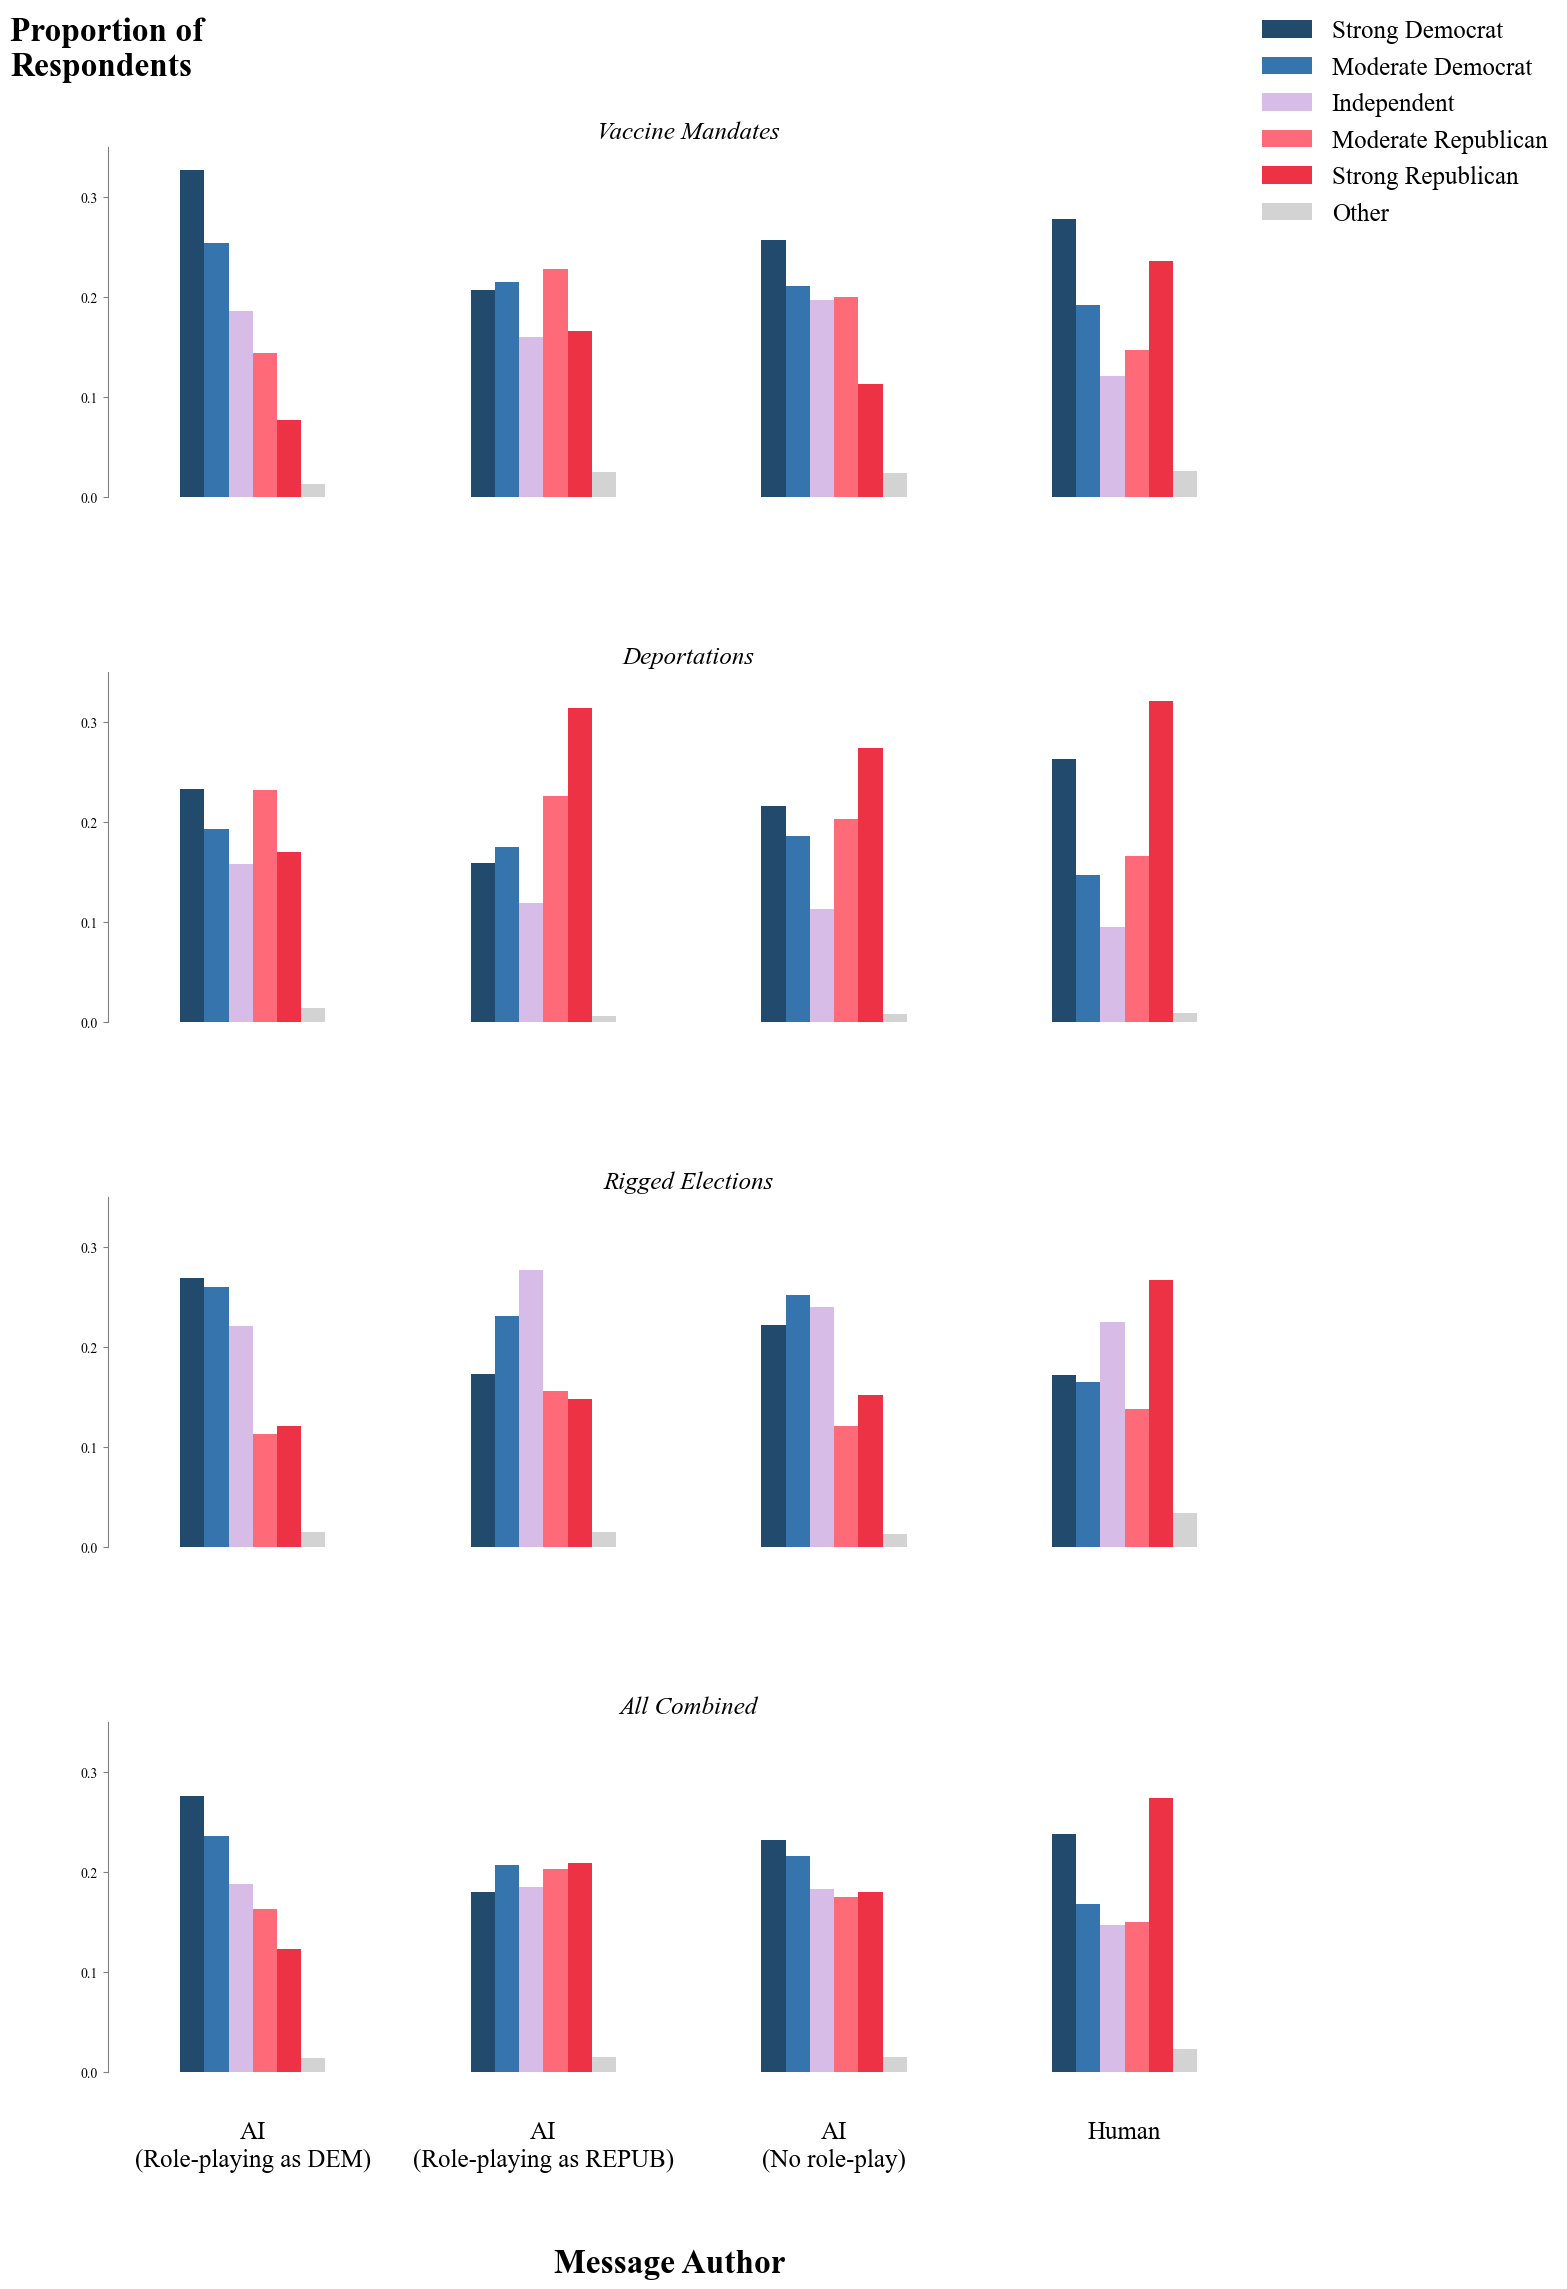

In [1]:
# ------------------------------
# FIG S2: AUTHOR PARTISANSHIP

# This code is used to generate the data and figures for Figure S2 in the paper.
# ------------------------------

# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Constants
FILE_PATH = '../data/final_dataset.csv'
RESPONSE_TYPES = ['dv_response_mean_vax', 'dv_response_mean_dep', 'dv_response_mean_elec', 'all']
X_AXIS_ORDER = ['dem', 'repub', 'no role-play', 'human']
X_AXIS_LABELS = ['AI\n(Role-playing as DEM)', 'AI\n(Role-playing as REPUB)', 'AI\n(No role-play)', 'Human']
AUTHOR_PARTISANSHIP_ORDER = ['Strong Democrat', 'Moderate Democrat', 'Independent', 'Moderate Republican', 'Strong Republican', 'Other']
COLOR_DICT = {partisanship: color for partisanship, color in zip(AUTHOR_PARTISANSHIP_ORDER, ['#224A6D', '#3674AD', '#D7BCE8', '#FF6A79', '#ED3245', '#d3d3d3'])}
PLOT_TITLES = ['Vaccine Mandates', 'Deportations', 'Rigged Elections', 'All Combined']

def prepare_data(file_path):
    df = pd.read_csv(file_path)
    reshaped_df = df.melt(id_vars='prolific_ID',
                          value_vars=['dv_response_mean_vax', 'dv_response_mean_dep', 'dv_response_mean_elec'],
                          var_name='response_type',
                          value_name='dv_response_mean')
    
    additional_columns = ['party', 'aligned', 'condition', 'treatment']
    for col in additional_columns:
        reshaped_df[col] = reshaped_df['prolific_ID'].map(df.set_index('prolific_ID')[col])
    
    partisanship_dict = {
        'dv_response_mean_vax': 'vax_partisanship',
        'dv_response_mean_dep': 'dep_partisanship',
        'dv_response_mean_elec': 'elec_partisanship'
    }
    
    prolific_indexed_df = df.set_index('prolific_ID')
    reshaped_df['author_partisanship'] = reshaped_df.apply(
        lambda row: prolific_indexed_df.loc[row['prolific_ID'], partisanship_dict[row['response_type']]],
        axis=1
    )
    
    reshaped_df['author_partisanship'].replace(
        to_replace=[r'Independent.*', r'Other.*'],
        value=['Independent', 'Other'],
        regex=True,
        inplace=True
    )
    
    return reshaped_df

def generate_figure(reshaped_df):
    plt.rcParams['font.family'] = 'Times New Roman'
    fig, axs = plt.subplots(4, 1, figsize=(15, 25))
    
    for i, (response_type, ax, title) in enumerate(zip(RESPONSE_TYPES, axs, PLOT_TITLES)):
        filtered_df = reshaped_df if response_type == 'all' else reshaped_df[reshaped_df['response_type'] == response_type]
        partisanship_distribution = filtered_df.groupby('treatment')['author_partisanship'].value_counts().unstack()
        partisanship_proportions = partisanship_distribution.divide(partisanship_distribution.sum(axis=1), axis=0).reindex(X_AXIS_ORDER)[AUTHOR_PARTISANSHIP_ORDER]
        partisanship_proportions.plot(kind='bar', ax=ax, color=[COLOR_DICT[col] for col in partisanship_proportions.columns])
        
        ax.yaxis.set_major_locator(MaxNLocator(nbins=4))
        ax.set_ylim(0, 0.35)
        ax.yaxis.set_tick_params(direction='out', color='grey')
        ax.yaxis.set_tick_params(which='both', labelcolor='black')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('grey')
        ax.spines['bottom'].set_visible(False)
        ax.set_title(title, fontname='Times New Roman', fontsize=18, style='italic', loc='center')
        
        if i != len(RESPONSE_TYPES) - 1:
            ax.set_xticks([])
        else:
            ax.set_xticklabels(X_AXIS_LABELS, rotation=0, fontname='Times New Roman', fontsize=18)
            ax.tick_params(axis='x', length=0, pad=35)
        
        axs[i].xaxis.label.set_visible(False)
        ax.legend().remove()
    
    fig.text(0.5, 0.03, 'Message Author', ha='center', fontname='Times New Roman', fontsize=24, weight='bold')
    fig.text(0.06, 0.919, 'Proportion of\nRespondents', va='center', rotation=0, fontname='Times New Roman', fontsize=24, weight='bold')
    fig.legend(loc='upper right', prop={'family': 'Times New Roman', 'size': 18}, labels=AUTHOR_PARTISANSHIP_ORDER, bbox_to_anchor=(1.1, 0.94), frameon=False)
    
    plt.subplots_adjust(hspace=0.5)
    plt.show()
    
    fig.savefig('author_partisanship.pdf', bbox_inches='tight')

def main():
    reshaped_df = prepare_data(FILE_PATH)
    generate_figure(reshaped_df)

if __name__ == "__main__":
    main()
